**Ex. 1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.base import clone

from scipy.io import loadmat

In [2]:
X, y = make_blobs(n_samples=500, n_features=2, centers=[[0, 0]], cluster_std=1.0, random_state=42)

Text(0.5, 1.0, 'Normal 2D dataset')

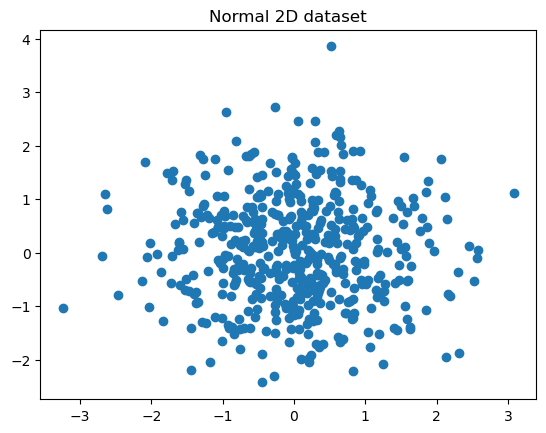

In [3]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.title("Normal 2D dataset")

In [4]:
unit_vectors = []

for i in range(5):
    v = np.random.multivariate_normal(mean=[0, 0], cov=np.eye(2))
    v = v / np.linalg.norm(v)
    unit_vectors.append(v)

unit_vectors=np.array(unit_vectors)

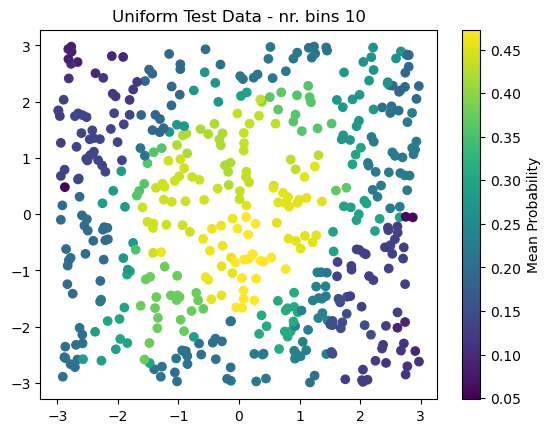

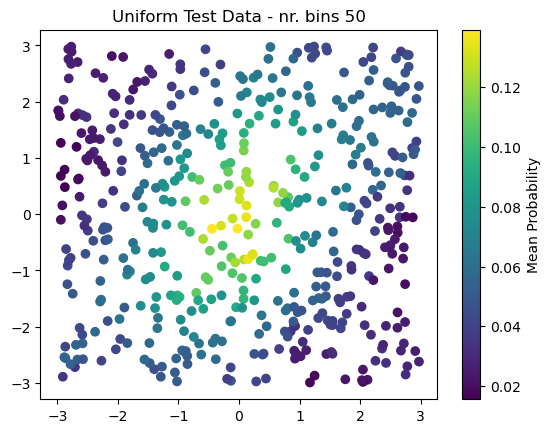

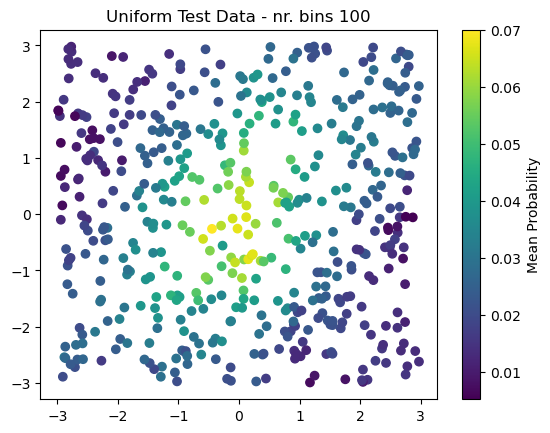

In [5]:
n_bins_list = [10, 50, 100]

X_test = np.random.uniform(-3, 3, size=(500, 2))

for n_bin in n_bins_list:
    scores = []
    prob_mats = []
    bin_edges_list = []
    for v in unit_vectors:
        v_proj = X @ v
        hist, bins = np.histogram(v_proj, bins=n_bin, range=(np.min(v_proj)-5, np.max(v_proj)+5))
        #plt.figure()
        #plt.hist(v_proj)
        prob = hist / np.sum(hist)
        prob_mats.append(prob)
        bin_edges_list.append(bins)
    
    prob_mats = np.array(prob_mats)
    
    for x in X:
        probs = []
        for i, v in enumerate(unit_vectors):
            proj = x @ v
            bins = bin_edges_list[i]
            prob = prob_mats[i]
            bin_idx = np.digitize(proj, bins) - 1
            bin_idx = np.clip(bin_idx, 0, len(prob) - 1)
            probs.append(prob[bin_idx])
        scores.append(np.mean(probs))
    
    scores = np.array(scores)

    test_scores = []
    
    for x in X_test:
        probs = []
        for i, v in enumerate(unit_vectors):
            proj = np.dot(x, v)
            bins = bin_edges_list[i]
            prob = prob_mats[i]
            bin_idx = np.digitize(proj, bins) - 1
            bin_idx = np.clip(bin_idx, 0, len(prob) - 1)
            probs.append(prob[bin_idx])
        test_scores.append(np.mean(probs))
    
    test_scores = np.array(test_scores)
    
    plt.figure()
    plt.scatter(X_test[:, 0], X_test[:, 1], c=test_scores, cmap='viridis')
    plt.colorbar(label='Mean Probability')
    plt.title(f"Uniform Test Data - nr. bins {n_bin}")

It seems that the bigger the number of bins, the more points are considered anomalies.


**Ex 2**

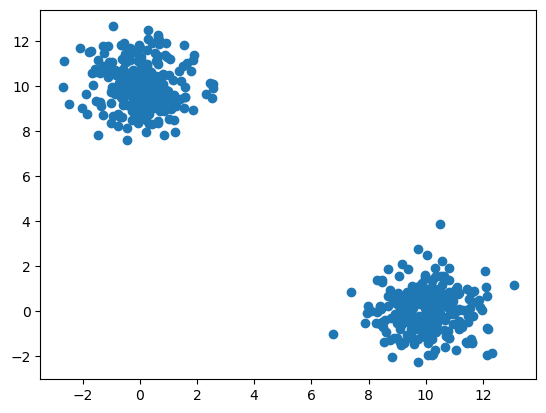

In [6]:
X, y = make_blobs(n_samples=500, n_features=2, centers=[[10, 0], [0, 10]], cluster_std=1, random_state=42)
plt.figure()
plt.scatter(X[:, 0], X[:, 1])

In [7]:
import warnings
warnings.filterwarnings("ignore", message=".*pin_memory.*")

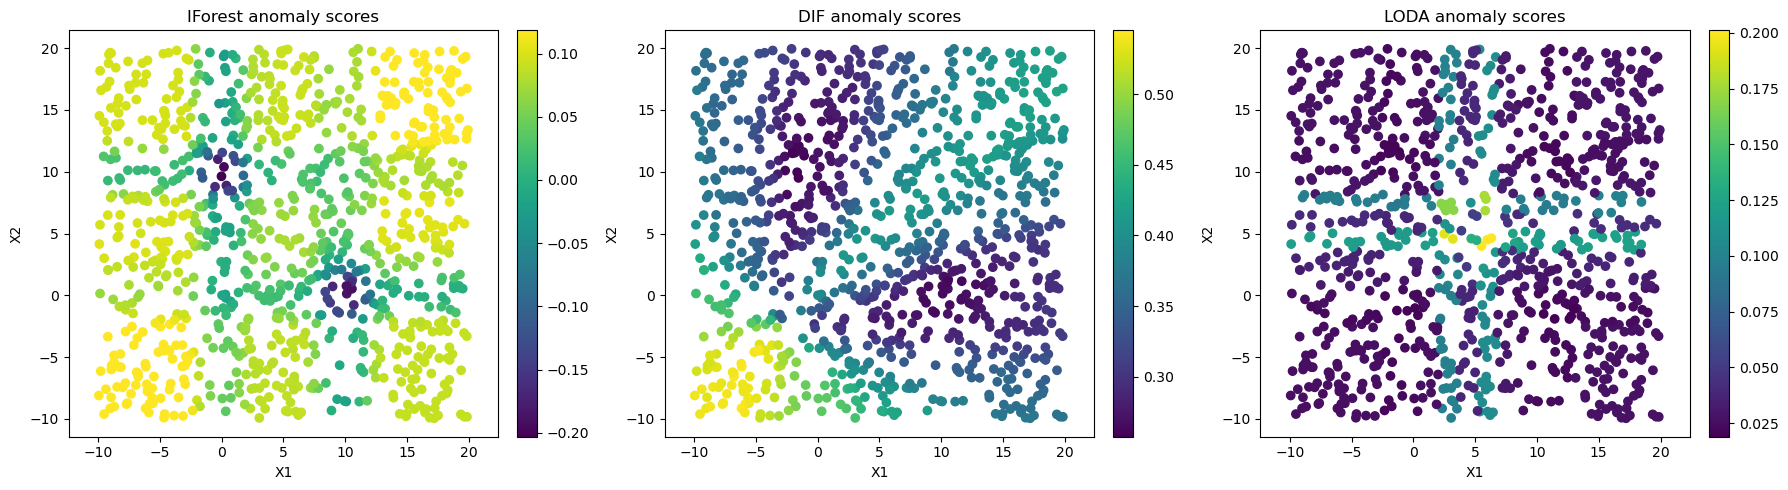

In [8]:
from pyod.models.iforest import IForest
from pyod.models.dif import DIF
from pyod.models.loda import LODA

X_test = np.random.uniform(-10, 20, size=(1000, 2))

models = {
    "IForest": IForest(contamination=0.02),
    "DIF": DIF(contamination=0.02),
    "LODA": LODA(contamination=0.02)
}

scores_dict = {}
for name, model in models.items():
    model.fit(X)
    scores_dict[name] = model.decision_function(X_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, scores) in zip(axes, scores_dict.items()):
    sc = ax.scatter(X_test[:, 0], X_test[:, 1], c=scores, cmap='viridis')
    ax.set_title(f"{name} anomaly scores")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.axis('equal')
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

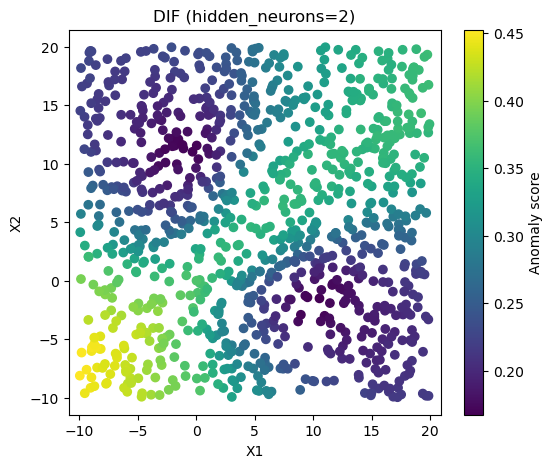

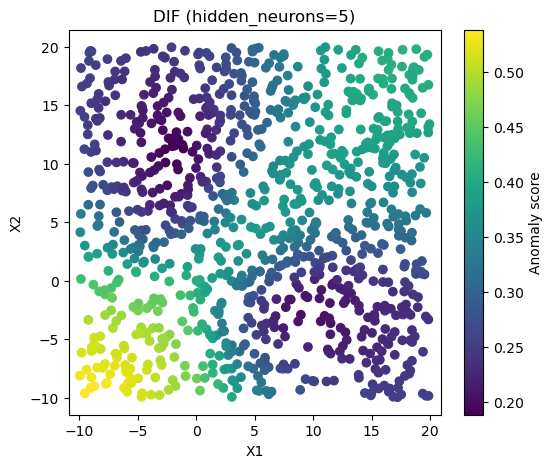

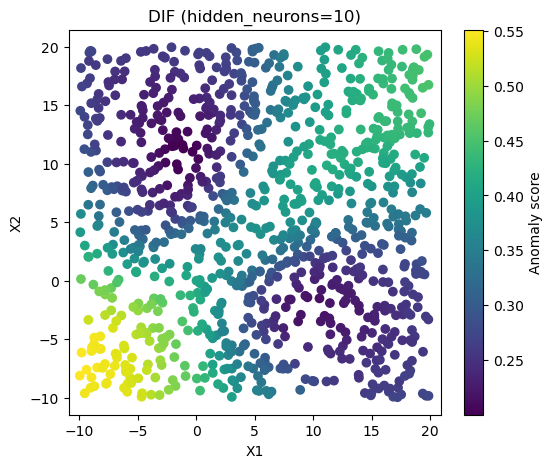

In [9]:
dif_neurons_list = [2, 5, 10]

for n_neurons in dif_neurons_list:
    dif = DIF(hidden_neurons=[n_neurons], contamination=0.02)
    dif.fit(X)
    dif_scores = dif.decision_function(X_test)
    
    plt.figure(figsize=(6,5))
    sc = plt.scatter(X_test[:,0], X_test[:,1], c=dif_scores, cmap='viridis')
    plt.colorbar(sc, label="Anomaly score")
    plt.title(f"DIF (hidden_neurons={n_neurons})")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.axis('equal')
    plt.show()

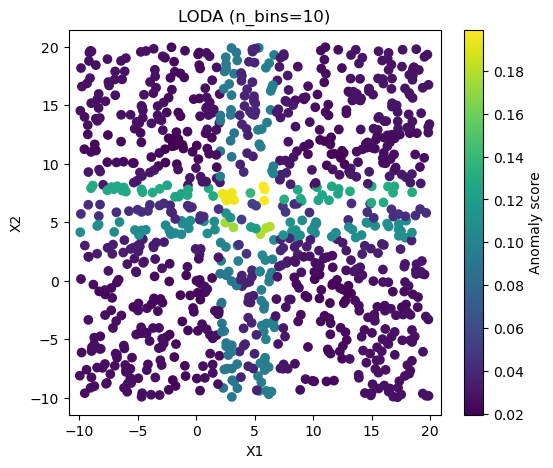

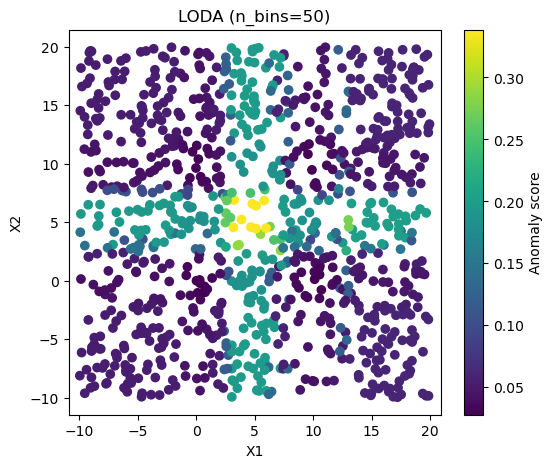

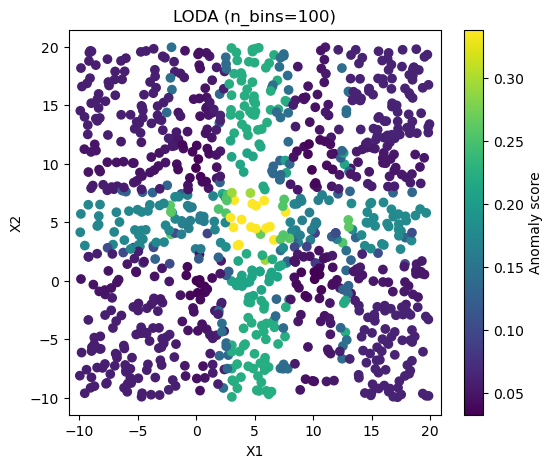

In [10]:
loda_bins_list = [10, 50, 100]

for n_bins in loda_bins_list:
    loda = LODA(n_bins=n_bins, contamination=0.02)
    loda.fit(X)
    loda_scores = loda.decision_function(X_test)
    
    plt.figure(figsize=(6,5))
    sc = plt.scatter(X_test[:,0], X_test[:,1], c=loda_scores, cmap='viridis')
    plt.colorbar(sc, label="Anomaly score")
    plt.title(f"LODA (n_bins={n_bins})")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.axis('equal')
    plt.show()

Points that are near the corners are marked as inliers by LODA, even though they are not from the normal blobs, because for each random projection they will fall in the same cluster on the line as one of the normal blobs. This is not the case from points from the central cross, which will be projected between the projections of the blobs.

**Same exercise - 3D**

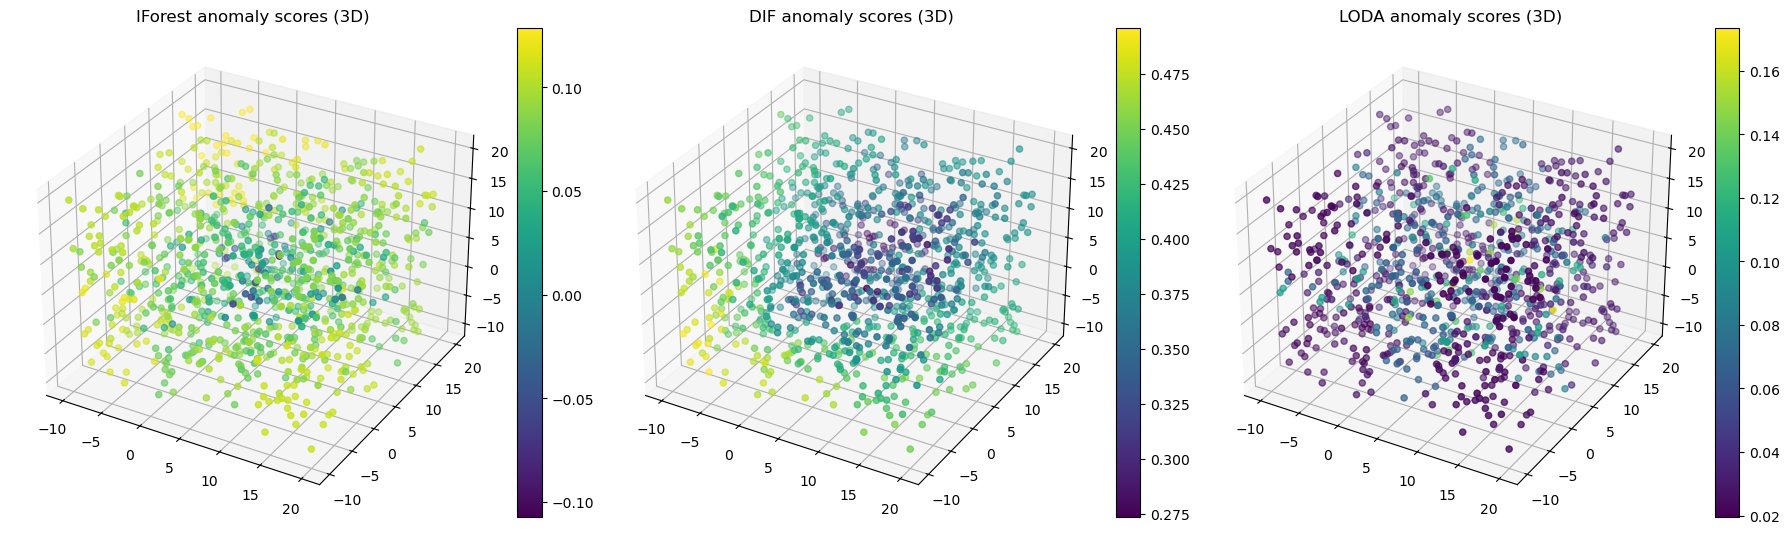

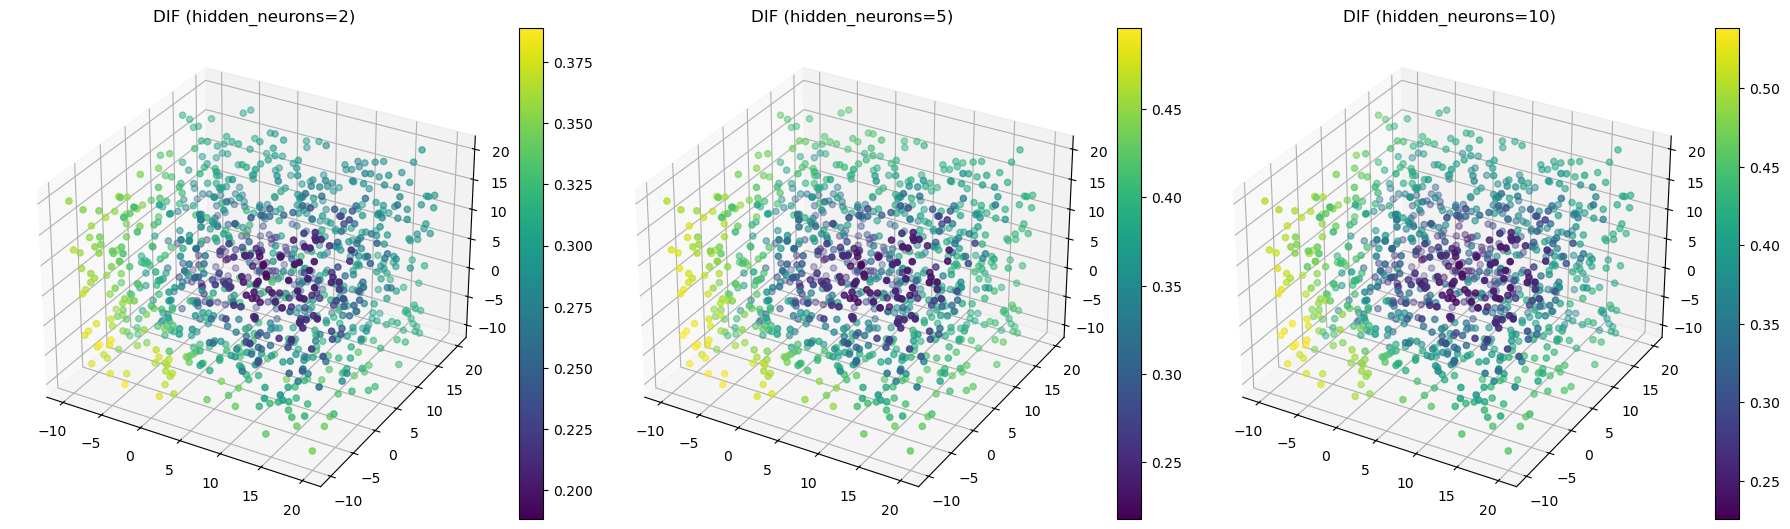

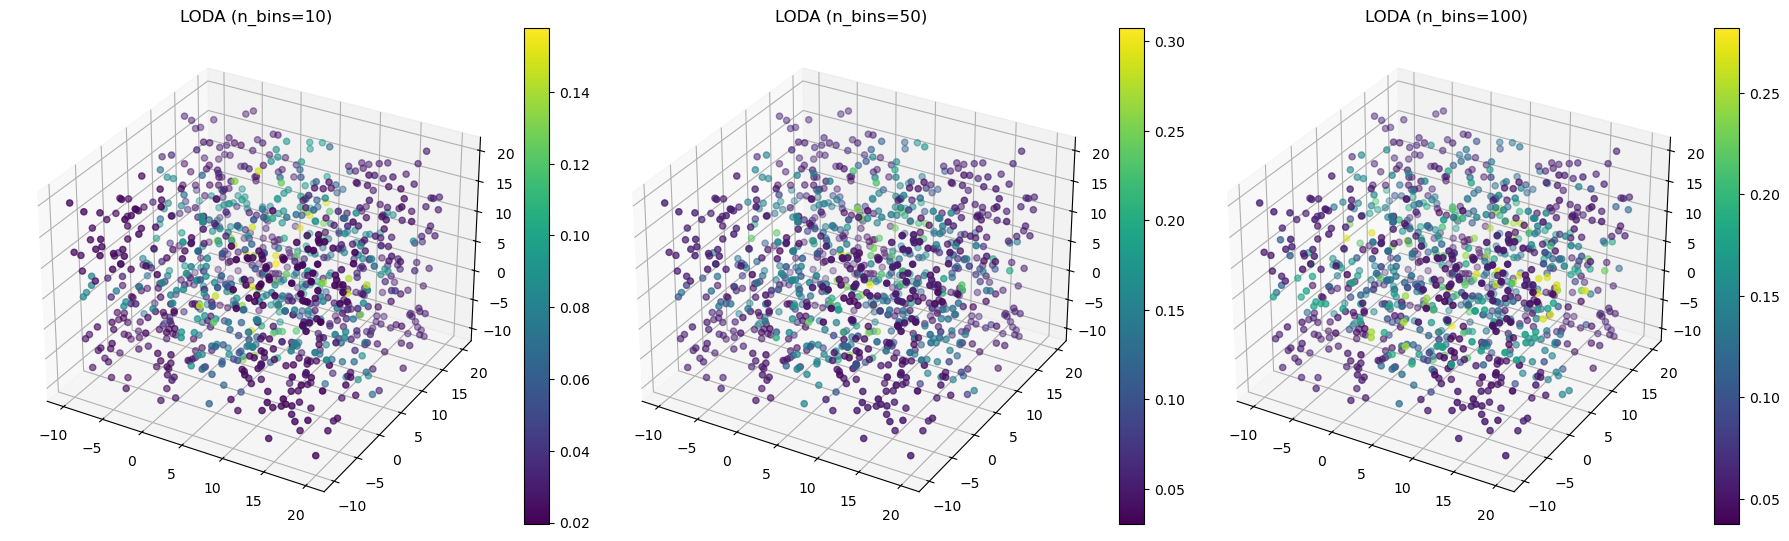

In [11]:
X, y = make_blobs(n_samples=500, n_features=3, centers=[[0, 10, 0], [10, 0, 10]], cluster_std=1, random_state=42)
X_test = np.random.uniform(-10, 20, size=(1000, 3))

models = {
    "IForest": IForest(contamination=0.02),
    "DIF": DIF(contamination=0.02),
    "LODA": LODA(contamination=0.02)
}

scores_dict = {}
for name, model in models.items():
    model.fit(X)
    scores_dict[name] = model.decision_function(X_test)

fig = plt.figure(figsize=(18, 6))
for i, (name, scores) in enumerate(scores_dict.items(), start=1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    sc = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=scores, cmap='viridis')
    ax.set_title(f"{name} anomaly scores (3D)")
    fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

dif_neurons_list = [2, 5, 10]
fig = plt.figure(figsize=(18, 6))
for i, n_neurons in enumerate(dif_neurons_list, start=1):
    dif = DIF(hidden_neurons=[n_neurons], contamination=0.02)
    dif.fit(X)
    dif_scores = dif.decision_function(X_test)
    
    ax = fig.add_subplot(1, 3, i, projection='3d')
    sc = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=dif_scores, cmap='viridis')
    ax.set_title(f"DIF (hidden_neurons={n_neurons})")
    fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

loda_bins_list = [10, 50, 100]
fig = plt.figure(figsize=(18, 6))
for i, n_bins in enumerate(loda_bins_list, start=1):
    loda = LODA(n_bins=n_bins, contamination=0.02)
    loda.fit(X)
    loda_scores = loda.decision_function(X_test)
    
    ax = fig.add_subplot(1, 3, i, projection='3d')
    sc = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=loda_scores, cmap='viridis')
    ax.set_title(f"LODA (n_bins={n_bins})")
    fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

**Ex. 3**

In [12]:
mat = loadmat('shuttle.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [13]:
X = mat['X']
y = mat['y'].ravel()

print(X.shape, y.shape)

(49097, 9) (49097,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
models = {
    "IForest": IForest(),
    "DIF": DIF(),
    "LODA": LODA()
}

results = {name: {"BA": [], "ROC": []} for name in models.keys()}

for seed in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    for name, model in models.items():
        clf = clone(model)
        clf.fit(X_train)
        y_scores = clf.decision_function(X_test)
        #y_pred = clf.predict(X_test)

        threshold = np.percentile(y_scores, 90)
        y_pred = (y_scores >= threshold).astype(int)
        
        ba = balanced_accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_scores)
        
        results[name]["BA"].append(ba)
        results[name]["ROC"].append(roc)

for name in models.keys():
    mean_ba = np.mean(results[name]["BA"])
    mean_roc = np.mean(results[name]["ROC"])
    print(f"{name}: Mean BA = {mean_ba:.4f}, Mean ROC AUC = {mean_roc:.4f}")

IForest: Mean BA = 0.9769, Mean ROC AUC = 0.9971
DIF: Mean BA = 0.8991, Mean ROC AUC = 0.9690
LODA: Mean BA = 0.7728, Mean ROC AUC = 0.8315
